In [1]:
import pandas as pd
import numpy as np
import glob
from os.path import basename
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

import re
import math

# Create Regressors

In [126]:
class data_loader:
    def __init__(self, subj, **kwargs):
        self.subj = int(subj)
        self.files = sorted(glob.glob('/home/songtao/ABA/bswift/dataset/behavioral/QSQ_{subj}/SUBJ{subj}_RUN*'.format(subj = self.subj)))
        self.runs = sorted(list(set([basename(i).split('_')[1] for i in self.files])))
        self.useRuns = [i for i in self.runs if i in ["RUN{0}".format(i) for i in range(1, 9)]]
        ## Speical case for ABA600
        if self.subj == 600:
            self.useRuns = [i for i in self.useRuns if i != 'RUN5']
        ## Remove excluded runs if applied
        if kwargs != {}:
            self.useRuns = [i[1] for i in [(idx+1, run) for idx, run in enumerate(self.useRuns)] 
                            if i[0] not in kwargs['excludeRuns']]
        
        
    def run_info(self, run, long=False):
        event = pd.read_csv([i for i in self.files if "event" in i if run in i][0])
        
        # Extract trials condition info for the run
        Rename = {'Shocked':'Rec', 'Touch':'Rec', 'Escaped':'NotRec', 
                  'Rewarded 100':'Rec', 'Rewarded 10':'Rec', 'Missed':'NotRec'}
        
        condInfo = event[event['kind'].isin(['Shocked', 'Touch', 'Escaped', 'Rewarded 100', 
                                             'Rewarded 10', 'Missed'])].replace(Rename)
        condInfo['Cond'] = condInfo['kind'] + '_' + condInfo['level'].replace({1:'high', 0:'low'}) + \
                            condInfo['encounter_type'].replace({1:'T', 0:'R'})
        condInfo = condInfo[['encounter', 'Cond']].reset_index(drop=True)
        
        ## Combine trials condition info with event df
        event = event.merge(condInfo, how='left', on='encounter')
        eventCols = ['play_start', 'play_end', 'isi_start', 'isi_end', 
                     'feedback_start', 'feedback_end', 'iti_start', 'iti_end']
        event = event[event['kind'].isin(eventCols)]
        
        # Combine ongoing time with event df, Long form
        ongoing = pd.read_csv([i for i in self.files if "ongoing" in i if run in i][0])
        ongoing['time'] -= ongoing['time'].values[0]
        
        df = event.merge(ongoing.drop(['kind'], axis=1), how='left', on=['frame', 'encounter'])
        df['Subj'] = self.subj
        df['Run'] = run
        df['Trial'] = df['encounter']
        df = df[['Subj', 'Run', 'Trial', 'time', 'kind', 'Cond']]
        
        ## Remove incomplete trials
        ### Check completion of trials
        complete = [(i, df[df['Trial'] == i].shape[0]) for i in df['Trial'].unique()]
        ### Remove incompleted trials
        for tri in complete:
            if (tri[1] < 8):
                df = df.drop(df[df['Trial'] == tri[0]].index)
                print("For ABA{0}, {1}: Last tiral is removed due to incompletion".format(self.subj, run))
            else:
                continue
        
        ## Turn df into short form
        if long:
            return df
        else:
            short = pd.concat([df[['Subj', 'Run', 'Trial', 'Cond']].drop_duplicates().reset_index(drop=True), 
                               df.pivot(columns='kind', values='time').apply(lambda x: x.dropna().to_numpy()).reset_index(drop=True)[eventCols]], 
                              axis=1)
            return short
        
    def concatRun_info(self, skip=True):
        if skip:
            runs = self.useRuns
        else:
            runs = self.runs
        
        out = []    
        for run in runs:
            out.append(self.run_info(run))
        out = pd.concat(out).reset_index(drop=True)
            
        return out
    
    def write_regressor(self, path, phase, condList, align='end', duration=False, df=None):
        if df is None:
            df = self.concatRun_info()
        col = ["{0}_start".format(phase), "{0}_end".format(phase)]
        
        out = {}
        condBool = True if len(condList) == 8 else False
        for cond in condList:
            if condBool:
                tmp = df[df['Cond'] == cond][['Run'] + col]
            else:
                tmp = df[df['Cond'].str.contains(cond)][['Run'] + col]
            res = []
            for run in self.useRuns:
                tmpSub = tmp[tmp['Run'] == run]
                item = "{0}_{1}".format(phase, align)
                time = tmpSub[item].tolist()
                if duration:
                    dur = (tmpSub[col[1]] - tmpSub[col[0]]).tolist()
                    res.append(["{0:.3f}:{1:.3f}".format(i, j) for i, j in zip(time, dur)])
                else:
                    res.append(["{0:.3f}".format(i) for i in time])
                if res[-1] == []:
                    res[-1] = ['*']
            out[cond] = res
            
        outPath = "/home/songtao/ABA/zoopsy/stimtimes/{0}/ABA{1}/regs/".format(path, self.subj)
        Path(outPath).mkdir(parents=True, exist_ok=True)
        
        for cond, values in out.items():
            filename = "ABA{subj}_{phase}_{cond}.txt".format(subj=self.subj, phase=phase, cond=cond)
            with open(outPath + filename, 'w') as f:
                for i in values[:-1]:
                    f.write("{0}\n".format("\t".join(i)))
                f.write("{0}".format("\t".join(values[-1])))
                
    def write_rest(self, path, df=None):
        if df is None:
            df = self.concatRun_info()
        rest_start = df.groupby(['Run'])['iti_end'].max().reset_index()
        rest_start = (rest_start['iti_end'] + 0.017).to_numpy()
        if self.subj == 600:
            volumns = 257
        elif self.subj == 601:
            volumns = 333
        else:
            volumns = 410
        rest_dur = volumns*1.25 - rest_start
        
        outPath = "/home/songtao/ABA/zoopsy/stimtimes/{0}/ABA{1}/regs/".format(path, self.subj)
        Path(outPath).mkdir(parents=True, exist_ok=True)
        filename = "ABA{subj}_rest.txt".format(subj=self.subj)
        
        with open(outPath + filename, 'w') as f:
            for i, j in zip(rest_start, rest_dur):
                if j >= 0:
                    f.write("{0:.3f}:{1:.3f}\n".format(i, j))
                else:
                    f.write("*\n")
                    print("Caution: behavioral log is longer than scan for ABA{subj}: {run}".format(subj=self.subj, run=np.where(rest_dur==j)[0][0] + 1))

In [124]:
cond4List = ['highT', 'lowT', 'highR', 'lowR']
cond8List = ["{0}_{1}".format(j, i) for i in cond4List for j in ['Rec', 'NotRec']]

In [125]:
subjList = sorted(glob.glob("/home/songtao/ABA/bswift/dataset/behavioral/QSQ_6??"))
subjList = [basename(i).split('_')[1] for i in subjList]

In [5]:
raw = []
for subj in subjList:
    tmp = data_loader(subj)
    if len(tmp.useRuns) > 0:
        raw.append(tmp.concatRun_info())
raw = pd.concat(raw).reset_index(drop=True)

For ABA600, RUN1: Last tiral is removed due to incompletion
For ABA600, RUN2: Last tiral is removed due to incompletion
For ABA600, RUN3: Last tiral is removed due to incompletion
For ABA600, RUN6: Last tiral is removed due to incompletion
For ABA600, RUN7: Last tiral is removed due to incompletion
For ABA600, RUN8: Last tiral is removed due to incompletion
For ABA601, RUN3: Last tiral is removed due to incompletion
For ABA601, RUN4: Last tiral is removed due to incompletion
For ABA601, RUN7: Last tiral is removed due to incompletion
For ABA601, RUN8: Last tiral is removed due to incompletion
For ABA628, RUN6: Last tiral is removed due to incompletion


In [163]:
data_loader(628).useRuns

['RUN1', 'RUN2', 'RUN3', 'RUN4', 'RUN5', 'RUN6', 'RUN7', 'RUN8']

# Remove motion excluded runs

In [120]:
exclude = pd.read_csv("~/ABA/bswift/scripts/first_level/runs_to_exclude.txt", header = 0, sep ='\t')
exclude = exclude[exclude['Reason'] == 'motion']

In [134]:
df = []
for subj in subjList:
    if subj not in ['605', '629', '678', '694']:
        if 'ABA{0}'.format(subj) in exclude['Subject'].unique():
            excludeRuns = exclude[exclude['Subject'] == 'ABA'+subj]['Run'].tolist()
            tmp = data_loader(subj, excludeRuns=excludeRuns)
        else:
            tmp = data_loader(subj)
        if len(tmp.useRuns) > 0:
            tmp_df = tmp.concatRun_info()
            tmp.write_regressor('stimtimes_4_conds_Realigned_end_reducedRuns', 'feedback', 
                                cond8List, align='start', df=tmp_df)
            tmp.write_regressor('stimtimes_4_conds_Realigned_end_reducedRuns', 'play', 
                                cond4List, align='end', df=tmp_df)
            tmp.write_rest('stimtimes_4_conds_Realigned_end_reducedRuns', df=tmp_df)
            df.append(tmp_df)
    else:
        continue
df = pd.concat(df).reset_index(drop=True)

For ABA600, RUN1: Last tiral is removed due to incompletion
For ABA600, RUN2: Last tiral is removed due to incompletion
For ABA600, RUN3: Last tiral is removed due to incompletion
For ABA600, RUN6: Last tiral is removed due to incompletion
For ABA600, RUN7: Last tiral is removed due to incompletion
For ABA600, RUN8: Last tiral is removed due to incompletion
For ABA601, RUN3: Last tiral is removed due to incompletion
For ABA601, RUN4: Last tiral is removed due to incompletion
For ABA601, RUN7: Last tiral is removed due to incompletion
For ABA601, RUN8: Last tiral is removed due to incompletion
Caution: behavioral log is longer than scan for ABA601: 1
Caution: behavioral log is longer than scan for ABA601: 5
For ABA628, RUN6: Last tiral is removed due to incompletion


In [146]:
x = data_loader(605).run_info('RUN1')

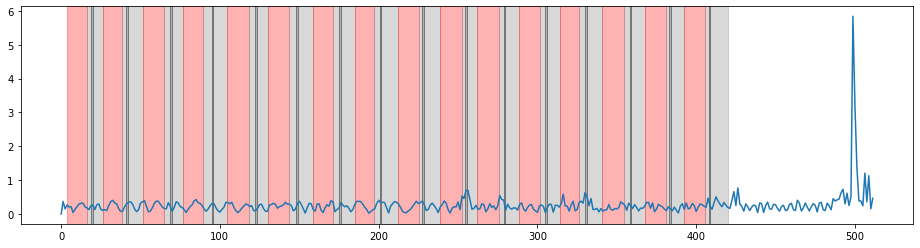

In [147]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(xx, yy)
for tri in x['Trial'].unique():
    tmp = x[x['Trial'] == tri]
    ax.axvspan(tmp['play_start'].values[0], tmp['play_end'].values[0], alpha=0.3, color='red')
    ax.axvspan(tmp['isi_start'].values[0], tmp['isi_end'].values[0], alpha=0.3, color='grey')
    ax.axvspan(tmp['iti_start'].values[0], tmp['iti_end'].values[0], alpha=0.3, color='grey')
    ax.axvspan(tmp['feedback_start'].values[0], tmp['feedback_end'].values[0], alpha=0.3, color='black')

In [148]:
x = data_loader(677).run_info('RUN3')
yy = [np.float64(i) for i in re.split(r"\s|\[|\]|\n", y[y['Subject'] == 'ABA677']['FD'].tolist()[0]) if i != '']
xx = np.arange(0, len(yy))*1.25

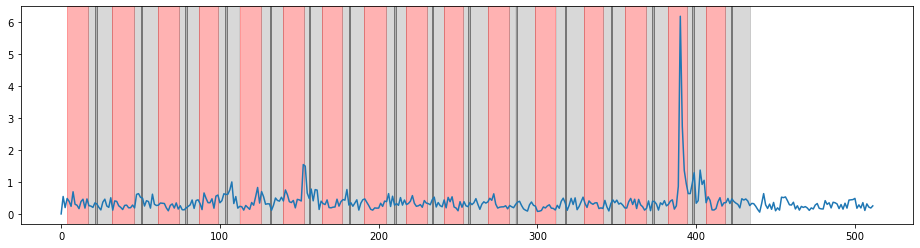

In [149]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(xx, yy)
for tri in x['Trial'].unique():
    tmp = x[x['Trial'] == tri]
    ax.axvspan(tmp['play_start'].values[0], tmp['play_end'].values[0], alpha=0.3, color='red')
    ax.axvspan(tmp['isi_start'].values[0], tmp['isi_end'].values[0], alpha=0.3, color='grey')
    ax.axvspan(tmp['iti_start'].values[0], tmp['iti_end'].values[0], alpha=0.3, color='grey')
    ax.axvspan(tmp['feedback_start'].values[0], tmp['feedback_end'].values[0], alpha=0.3, color='black')